In [1]:

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import scipy.sparse as sparse
import random
import numpy as np


from subprocess import call
from sklearn.metrics import mean_squared_error
df = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/AMLAS/ml-latest-small/ml-latest-small/ratings.csv")
from math import sqrt

import math
from sklearn.metrics import roc_auc_score
movieList = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/AMLAS/ml-latest-small/ml-latest-small/movies.csv")


In [2]:
uniqueMovies = df["movieId"].unique()
user = df["userId"].unique()


In [3]:
data = np.zeros((uniqueMovies.shape[0],2))

for i in range(uniqueMovies.shape[0]):
    data[i,0] = int(i)
    data[i,1] = uniqueMovies[i]
    
    
movieData = pd.DataFrame(data, columns = ['newId', 'movieId'])
movieData

def MovieIndx(df,id):
    x = df.loc[df["movieId"] == id]
    y = x.iat[0,0]
    return y

def queryUser(df,id):
    
    return df.loc[df["userId"] == id]


def queryMovie(df,id):
    
    
    return df.loc[df["movieId"] == id]

def revMovieIndx(df,id):
    x = df.loc[df["newId"] == id]
    y = x.iat[0,1]

    return y

def getMovieName(movieId,df):
    x = df.loc[df["movieId"] == movieId]
    
    return x.title

In [4]:
bin_rating = np.zeros((df.shape[0]))
i = 0
for row in df.itertuples(index = False):
    
   
        user_max = queryUser(df,row.userId)['rating'].max()
        user_min = queryUser(df,row.userId)['rating'].min()
        if (user_max<4 and row.rating == user_max):
            
            bin_rating[i] = 1
            
        if(row.rating >= 4 and user_max>=4):
            
            bin_rating[i] = 1
            
        
        i = i +1  
        
df_n = df

df_n["binRatings"] = bin_rating




In [5]:
train = df_n


In [8]:
def fit(train,n_factors,epocs,movieData):
    
    
 
    lambda_1 = 0.1
    tau = 5/sqrt(n_factors)
    lr = 0.1
    n_iters = 1000
    
    n_users, n_movies = len(train["userId"].unique()),len(train["movieId"].unique())
    user_factors = np.random.normal(0,sqrt(lambda_1),size = (n_factors,n_users))
    movie_factors = np.random.normal(0,sqrt(lambda_1),size = (n_factors,n_movies))
    ers = []
    
    for e in range(epocs):
    
        for i in range(n_iters):
        
            user_factors,movie_factors = sample(train,user_factors,movie_factors,lr,movieData,lambda_1)
        

        
     

        a = auc(train,user_factors,movie_factors,movieData)
        ers = np.append(ers,a)

    return user_factors, movie_factors,ers

def sample(train,user_factors,movie_factors,lr,movieData,lambda_1):
    
    x = np.random.randint(1,user_factors.shape[1]+1, size=1)
    
    user_batch = queryUser(train,x[0])
    pos_batch = user_batch[user_batch.binRatings == 1]
    neg_batch_user = user_batch[user_batch.binRatings == 0]
    neg_batch_rest = train[train.userId != x[0]]
    all_negs = pd.concat([neg_batch_user, neg_batch_rest], ignore_index=True)

    xif = pos_batch.sample()

    xjf = all_negs.sample()
   
    i_ind = int(MovieIndx(movieData,int(xif.movieId)))
    j_ind = int(MovieIndx(movieData,int(xjf.movieId)))


    user_u = user_factors[:,x[0]-1]
    item_i = movie_factors[:,i_ind]
    item_j = movie_factors[:,j_ind]

    r_ui = user_u.T@item_i
    r_uj = user_u.T@item_j
    r_uij = r_ui - r_uj

    sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))

    grad_u = sigmoid * (item_j - item_i) + lambda_1* user_u
    grad_i = sigmoid * -user_u + lambda_1* item_i
    grad_j = sigmoid * user_u + lambda_1* item_j


    user_factors[:,x[0]-1] -= lr*grad_u
    movie_factors[:,i_ind] -= lr*grad_i
    movie_factors[:,j_ind] -= lr* grad_j
    
 

    return user_factors,movie_factors

def prediction(df,user_factors,movie_factors):
    
    preds = np.zeros(len(df))
    i = 0
    for row in df.itertuples(index = False):
        
        user = row.userId -1
        movie = int(MovieIndx(movieData,row.movieId))
        
        preds[i] = user_factors[:,user].T@movie_factors[:,movie]
        
    return preds
        
def predict(df,user_factors,movie_factors):
    
    preds = np.zeros(len(df))
    i = 0
    for row in df.itertuples(index = False):
        
        user = row.userId -1
        movie = int(MovieIndx(movieData,row.movieId))
        
        preds[i] = user_factors[:,user].T@movie_factors[:,movie]
        
    return preds   

def auc(df,user_factors,movie_factors,movieData):
    
    auc = 0
    

    
    for i in range(user_factors.shape[1]):
    
        user  = i +1
        true_movie_rs = np.zeros(movie_factors.shape[1])
        
        user_batch = queryUser(df,user)
        user_batch = user_batch[user_batch.binRatings == 1]
        
        for row in user_batch.itertuples(index= False):
            
            movie = int(MovieIndx(movieData,row.movieId))
            
            true_movie_rs[movie] = 1
        
        
            
        
        y_pred = user_factors[:,i].T@movie_factors
        
        auc += roc_auc_score(true_movie_rs,y_pred)
    
    auc/=user_factors.shape[1]
    return auc
    

def createreco(userId,user_factors,movie_factors,df,movieData,movieList):

    
  
    list = user_factors[:,userId-1].T@movie_factors
    list = np.reshape(list,(1,movie_factors.shape[1]))
    
    movieIds = np.zeros(8)
    
        

    userList = df[df.userId == userId]  

    for row in userList.itertuples(index=False):
        index = int(MovieIndx(movieData,row.movieId))
        list[0,index] = 0
                    
  
    sort_index = np.argsort(list)
    topFive = sort_index[0,-8:]
    recList = []
    for i in range(len(topFive)):
        ind = int(topFive[i])
        x = revMovieIndx(movieData,ind)
        
        movieIds[i] = x
        movieName = getMovieName(x,movieList)
        movieGenres = movieList.genres[movieList.movieId == x]
        movieSum = [movieName ,movieGenres]
        recList = np.append(recList,movieSum)
        
   
    return recList,movieIds

def checkPref(df,userId,movieList):
    
    userList = df[df.userId == userId]
    sortedList = userList.sort_values("rating")
    topFive = sortedList.tail(10)
    recList = []
    movieIds = np.zeros(10)
    i = 0
    
    for row in topFive.itertuples(index = False):
        
        
            movieIds[i] = int(row.movieId)
            movieName = getMovieName(row.movieId,movieList)
            movieGenres = movieList.genres[movieList.movieId == row.movieId]
            movieSum = [movieName ,movieGenres]
            recList = np.append(recList,movieSum)
            i = i+1
    return recList,movieIds
    
    



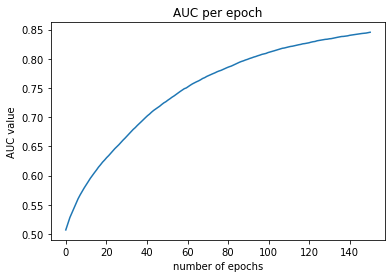

In [9]:
#train model and plot AUC

u,m,ac = fit(train,40,150,movieData)

x =np.linspace(0,150,150)
plt.plot(x,ac)
plt.title("AUC per epoch")
plt.ylabel("AUC value")
plt.xlabel("number of epochs")
plt.savefig("AUC.png")


In [ ]:
def printMovies(Mlist):
  
    print("movie recommendations:")
    print("-------------------------")
  
    for i in range(len(Mlist)):
        if i%2 ==0:
            print("movieName: ", Mlist[i])
        
        else:
            print("movieGenres: " , Mlist[i])
            print('\n')
    print('\n')

In [ ]:

recs,ids = createreco(500,u,m,df,movieData,movieList)


printMovies(recs)
print(ids)